The C++ implementation is rather straitforward rewriting of python stochastic procedures from (). You can find source files in cpp folder. It was compiled by MS VisualStudio 2017 and uses some C++17 features. Compiled executable stochastic.exe is for 64bit Windows OS. For other OS you can compile the files yourself on any appropriate C++ compiler supporting C++17 standard. To pass parameters to the application configuration file config.txt is used. Results are written in dynamics.txt and tests.txt files. The application (stochastic.exe) gets directory for config.txt,dynamics.txt, and tests.txt files as command string parameter -d. So python interface for stochastic.exe is following:

In [6]:
import matplotlib.pyplot as plt
import os
import time
# to not repead HCS_SIR and HCS_SIR2 implementation we place it into separate file
from hcs_sir import * 


def exec_SIR(r0_0,I0,τ,vs0,vb0,
             vcb=0.4,nlp=0.5,tp=0.25,elr=0.0,ps=80000,
             sn=50,mtl=100,seed=317,exec_type=0,
             s_rate=0,dir='c:\\tmp'):
    command=f'stochastic.exe -d"{dir}"'
    with open(dir+"\\config.txt", "rt") as file:
        conf=dict(np.loadtxt(file,dtype=('U32,f8')))
    conf["final_time"]=modeling_period+3
    conf["simulations_number"]=sn
    conf["min_trace_len"]=mtl
    conf["resample_step"]=t_step
    conf["population_size"]=ps
    conf["initial_R0"]=r0_0
    conf["variance_of_social_activity"]=vs0
    conf["variance_of_catchability"]=vb0
    conf["variance_of_spreadability"]=vcb
    conf["inverse_tau"]=1.0/τ
    conf["new_lineage_prob"]=nlp
    conf["test_prob"]=tp
    conf["external_lineages_rate"]=elr
    conf["initial_seed"]=seed
    
    #exec_type
    #0 - SIR dynamics (correspond to HCS_SIR2) & lineage distribution 
    #1 - SIR dynamics (correspond to HCS_SIR)
    #2 - SIR dynamics (correspond to HCS_SIR) another method
    #3 - SIRS dynamics (correspond to HCS_SIR2)
    conf["exec_type"]=exec_type
    conf["s_rate"]=s_rate
    
    with open(dir+"\\config.txt", "wt") as file:
        for k in conf:
            file.write(f'{k} {conf[k]}\n')
    time.sleep(1)        
    return os.system(command)


To get dynamics we need a procedure to read it from the file and we can compare it with HCS_SIR model. The procedure reads the results  from dynamics.txt file. The file contains four columns:#trace, time, Suscectible number, Infectious number. The procedure splits results by trace number. For each trace it normalizes the values to $[0,1]$ interval, throws the values below I0, throws traces shorter than m_l, and cuts the tails of the traces to make the lengths of the traces the same. 

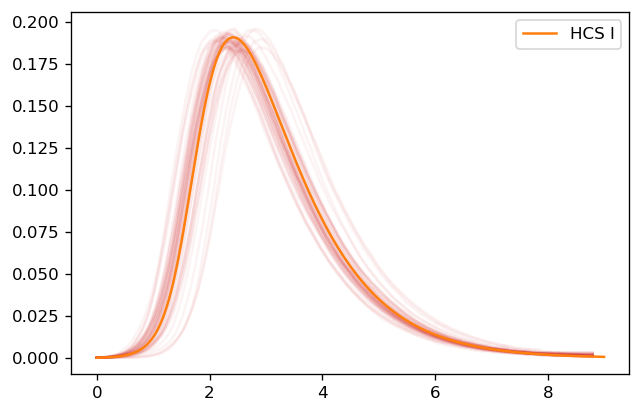

In [11]:
def dynamics_from_file(I0,l_m=100,path="c:\\tmp"):
    with open(path+"\\dynamics.txt", "rt") as file:
        trace_numb,T,S,I=np.loadtxt(file).T
    resT=[]    
    resS=[]    
    resI=[]
    l_min=100000000;
    TN=int(trace_numb[-1])+1
    for tn in range(TN):
        mask=(trace_numb==tn)
        t=T[mask]
        s=S[mask]
        i=I[mask]
        N=s[0]+i[0]
        s/=N
        i/=N
        pos=np.argmax(i>I0)
        t=t[pos:]
        s=s[pos:]
        i=i[pos:]
        l=len(t)
        if l>l_m:
            if(l<l_min):l_min=l
            resT.append(t-t[0])
            resS.append(s)
            resI.append(i)
    l_min-=1    
    for tn in range(len(resT)):
        resT[tn]=resT[tn][:l_min]
        resS[tn]=resS[tn][:l_min]
        resI[tn]=resI[tn][:l_min]
    return np.vstack(resT), np.vstack(resS),np.vstack(resI) 

vs0=0.7
vb0=0.2
r0_0=5.2
I0=0.0002
τ=0.4
exec_SIR(r0_0,I0,τ,vs0,vb0,exec_type=1)
T,S,I=dynamics_from_file(I0);
fig, ax = plt.subplots(dpi=120)
for t,i in zip(T,I):
    plt.plot(t, i,color='C3', alpha=0.05)
s,i=HCS_SIR(r0_0,I0,τ,vs0,vb0)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()


It is interesting to draw the average of stochastic traces. As you can see the stochastic traces looks similarly but have different time lag. So to get correct average value we need to average rather time lags than the values.

In [14]:
def get_avr_trace(t,S,I):
    trace_numb,trace_len=I.shape
    cut_v=np.amax(I, axis=1).mean()/2
    shifts=np.argmax(I>cut_v, axis=1)
    shifts=int(shifts.mean())-shifts
    sum_I=np.zeros(trace_len)
    sum_S=np.zeros(trace_len)
    sum_n=np.zeros(trace_len)
    for tn in range(trace_numb):
        sh=shifts[tn]
        mask=np.ones(trace_len,dtype=np.bool)
        if(sh>=0):
            mask[:sh]=False
        else:
            mask[sh:]=False
        sum_I+=np.roll(I[tn],sh)*mask
        sum_S+=np.roll(S[tn],sh)*mask
        sum_n+=mask
    s,i=sum_S/sum_n,sum_I/sum_n
    l=min(len(t),trace_len)
    return t[:l],s[:l],i[:l]    


Now we can compare HCS_SIR and average of stochastic SIR and get pretty good match:

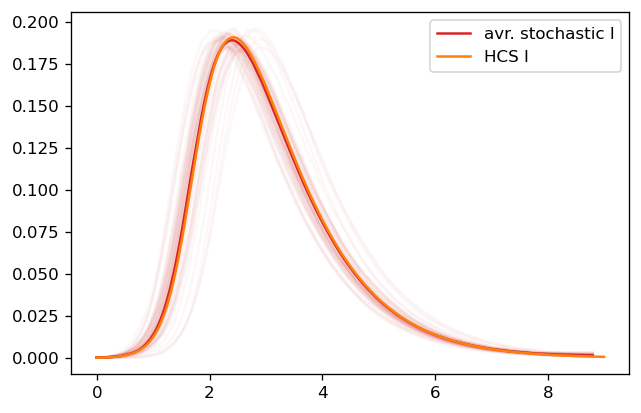

In [16]:
fig, ax = plt.subplots(dpi=120)
for t,i in zip(T,I):
    plt.plot(t, i,color='C3', alpha=0.03)
t,s,i=get_avr_trace(m_t,S,I)
plt.plot(t, i,color='C3', label=f'avr. stochastic I')    
s,i=HCS_SIR(r0_0,I0,τ,vs0,vb0)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()